# ETA Project
By Yihnew Eshetu

In [290]:
import pandas as pd
import numpy as np
import re
import plotly_express as px
import seaborn as sns
import os
import nltk
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from glob import glob
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.spatial.distance import pdist

## Create TOKEN, LIB, and VOCAB

### OHCO Level

In [ ]:
OHCO = ['file_id', 'company', 'title', 'speaker', 'sent_num', 'token_num']

In [229]:
def readTxt(file_list):
    lib = []
    doc = []
    count = 0
    for file_name in file_list:
        file = open(file_name, 'r', encoding='ISO-8859-1').read()
        if re.search('\sQUESTIONS\sAND\sANSWERS\s-', file, re.I) is not None:
            txt = re.sub('COMPANY\sDISCLAIMERS\sImportant(.+)', '', file, flags=re.I)
            txt = re.sub('\sQUESTIONS\sAND\sANSWERS\s-', '  QUESTIONS AND ANSWERS - ', txt, flags=re.I)
        elif re.search('\s\sQUESTIONS\sAND\sANSWERS\s', file, re.I) is not None:
            txt = re.sub('COMPANY\sDISCLAIMERS\sImportant(.+)', '', file, flags=re.I)
            txt = re.sub('\s\sQUESTIONS\sAND\sANSWERS\s', '  QUESTIONS AND ANSWERS - ', txt, flags=re.I)
        else:
            count += 1
            continue
                    
        txt = re.split('\s\sQUESTIONS\sAND\sANSWERS\s-\s', txt, re.I)
        
        title = txt[0].split('--')[0].split('\t"')[1].split('  ')
        report_title = title[0]
        date = re.search(r'[a-z]+\s(\d{2}|\d{1}),\s\d{4}', title[1], re.I).group()
        
        txt = re.sub('^------------------------------------------------------------------------------- ', '', txt[1])
        txt = re.sub('\s\s', ' -------------------------------------------------------------------------------- ', txt)
        txt = re.sub('\[([0-9]+)\]', '[1] -------------------------------------------------------------------------------- ', txt)
        txt = re.split(r' -------------------------------------------------------------------------------- ', txt)
        
            
        df = pd.DataFrame(txt, columns=['line_str'])
        
        company = file_name.split('/')[0]
        file_id = file_name.split('/')[1].split('_')[0]
        df['file_id'] = file_id
        df['company'] = company
        
        
        df['title'] = report_title

        speakers_lines = df.line_str.map(lambda x: str(x)[-4:].strip()).str.lower().str.match(pat = '[\[]+[0-9]+') 
        speakers = [i for i in df.loc[speakers_lines].line_str.map(lambda x: str(x).split(',')[0].split(' [')[0]).values]
        df.loc[speakers_lines, 'speaker'] = speakers
        df.speaker = df.speaker.ffill()
        df = df.loc[~df.speaker.isna()] 
        df = df.loc[~speakers_lines]
        
        # Speaker
        df['line_str'] = df['line_str'].str.strip()
        dfc = df.groupby(OHCO[:4]).line_str.apply(lambda x: '\n'.join(x)).to_frame() # Make big string
    
        # Sentence
        dfc['line_str'] = dfc['line_str'].str.strip()
        dfc = dfc[~dfc['line_str'].str.match(r'^\s*$')]
        dfs = dfc['line_str'].str.split(r'[.?!;:"]+', expand=True).stack().to_frame().rename(columns={0:'sent_str'})
        dfs.index.names = OHCO[:5]
        
        # Token
        dfs['sent_str'] = dfs['sent_str'].str.strip()
        dft = dfs['sent_str'].str.split(r"[\s',-]+", expand=True).stack().to_frame().rename(columns={0:'token_str'})
        dft.index.names = OHCO[:6]
        
        lib.append((file_id, company, date, report_title, file_name))
        doc.append(dfc)
        
    #print(count)
    library = pd.DataFrame(lib, columns=['file_id', 'company', 'date', 'title', 'file_name']).set_index('file_id')
    docs = pd.concat(doc)
    return docs, library

### Read in Files

In [230]:
companies = ['Cisco', 'IBM', 'Intel', 'Verizon']
list_files = [file for company in companies for file in sorted(glob(company + '/*.txt'))]
#list_files = ['Cisco/575f8b498cfe5b23768b45e8_CSCO.txt']
doc, lib = readTxt(list_files)

In [233]:
doc

line_str
file_id                  company title                                              speaker                                                          
575f8b498cfe5b23768b45e8 Cisco   Q3 2016 Cisco Systems Inc Earnings Call            Brent Bracelin  Thank you for taking the question. Chuck, I wa...
                                                                                    Brian White     I'm wondering if you could walk us through wha...
                                                                                    Chuck Robbins   Ittai, this is Chuck. Thanks for the questions...
                                                                                    Ittai Kidron    Thanks, and congrats on great execution. First...
                                                                                    James Faucette  Great, thank you very much. I just had a clari...
...                                                                                                                                               ...
5911266a6bfe09c7088b4567 Verizon Verizon Communications Inc Analyst Meeting Webc... Walter Piecyk   Walt Piecyk. I just want to go back to Jennife...
                                                                                    William Power   Will Power. So maybe just building on that que...
591c5f366bfe09f6098b4567 Verizon Verizon Communications Inc at MoffettNathanson ... Craig Moffett   Obviously, one of the themes that we're going ...
                                                                                    Editor          ----------------------------------------------...
                                                                                    Matt Ellis      Yes, so good morning, Craig, and great to be h...

[12413 rows x 1 columns]

### LIBRARY

In [234]:
lib.to_csv('LIBRARY.CSV')

### TOKEN

In [236]:
#### Function for Tokenizing doc

In [237]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.line_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x)))
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [238]:
TOKEN = tokenize(doc, ws=True)
# Remove white space
TOKEN['term_str'] = TOKEN['token_str'].str.lower().str.replace('[\W_]', '')

### VOCAB

In [240]:
# Create VOCAB from TOKEN table
VOCAB = TOKEN.term_str.value_counts().to_frame().rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB.index.name = 'term_id'
# Check if a term string is a number
VOCAB['num'] = VOCAB.term_str.str.match("\d+").astype('int')

In [241]:
# Stem VOCAB term string
stemmer = PorterStemmer()
VOCAB['p_stem'] = VOCAB.term_str.apply(stemmer.stem)
# Add term id to TOKEN table
TOKEN['term_id'] = TOKEN.term_str.map(VOCAB.reset_index().set_index('term_str').term_id)
# Add part of speech max to VOCAB table
VOCAB['pos_max'] = TOKEN.groupby(['term_id', 'pos']).count().iloc[:,0].unstack().idxmax(1)

In [242]:
# Remove empty term string rows in TOKEN and VOCAB table
TOKEN = TOKEN[~TOKEN.term_str.isna()]
VOCAB = VOCAB[~VOCAB.term_str.isna()]

In [243]:
TOKEN.head()

pos_tuple  \
file_id                  company title                                   speaker        sent_num token_num                  
575f8b498cfe5b23768b45e8 Cisco   Q3 2016 Cisco Systems Inc Earnings Call Brent Bracelin 0        0           (Thank, NNP)   
                                                                                                 1             (you, PRP)   
                                                                                                 2              (for, IN)   
                                                                                                 3          (taking, VBG)   
                                                                                                 4              (the, DT)   

                                                                                                            pos  \
file_id                  company title                                   speaker        sent_num token_num        
575f8b498cfe5b23768b45e8 Cisco   Q3 2016 Cisco Systems Inc Earnings Call Brent Bracelin 0        0          NNP   
                                                                                                 1          PRP   
                                                                                                 2           IN   
                                                                                                 3          VBG   
                                                                                                 4           DT   

                                                                                                           token_str  \
file_id                  company title                                   speaker        sent_num token_num             
575f8b498cfe5b23768b45e8 Cisco   Q3 2016 Cisco Systems Inc Earnings Call Brent Bracelin 0        0             Thank   
                                                                                                 1               you   
                                                                                                 2               for   
                                                                                                 3            taking   
                                                                                                 4               the   

                                                                                                           term_str  \
file_id                  company title                                   speaker        sent_num token_num            
575f8b498cfe5b23768b45e8 Cisco   Q3 2016 Cisco Systems Inc Earnings Call Brent Bracelin 0        0            thank   
                                                                                                 1              you   
                                                                                                 2              for   
                                                                                                 3           taking   
                                                                                                 4              the   

                                                                                                            term_id  
file_id                  company title                                   speaker        sent_num token_num           
575f8b498cfe5b23768b45e8 Cisco   Q3 2016 Cisco Systems Inc Earnings Call Brent Bracelin 0        0            26308  
                                                                                                 1            29413  
                                                                                                 2            11078  
                                                                                                 3            25912  
                                               

In [244]:
VOCAB.head()

,term_str,n,num,p_stem,pos_max
term_id,,,,,
0,,28456,0,,:
1,0,46,1,0,CD
2,00,9,1,00,VB
3,0001,1,1,0001,CD
4,0004,2,1,0004,NN


In [245]:
TOKEN.to_csv('TOKEN.csv')
VOCAB.to_csv('VOCAB.csv')

## TFIDF

In [246]:
def tfidf(TOKEN, bag, count_method, tf_method, idf_method):
    # Bag of Words
    BOW = TOKEN.groupby(bag+['term_id']).term_id.count().to_frame().rename(columns={'term_id':'n'})
    BOW['c'] = BOW.n.astype('bool').astype('int')
    
    # Document Count Matrix
    DTCM = BOW[count_method].unstack().fillna(0).astype('int')

    # Compute TF
    tf_norm_k = .5
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log10(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
        TF = tf_norm_k + (1 - tf_norm_k) * TF[TF > 0] # EXPLAIN; may defeat purpose of norming
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    
    # Compute DF
    DF = DTCM[DTCM > 0].count()
    
    # Compute IDF
    N = DTCM.shape[0]
    if idf_method == 'standard':
        IDF = np.log10(N / DF)
    elif idf_method == 'max':
        IDF = np.log10(DF.max() / DF) 
    elif idf_method == 'smooth':
        IDF = np.log10((1 + N) / (1 + DF)) + 1 # Correct?
    
    # TFIDF
    TFIDF = TF * IDF
    return TFIDF

if 'term_rank' not in VOCAB.columns:
    VOCAB = VOCAB.sort_values('n', ascending=False).reset_index()
    VOCAB.index.name = 'term_rank'
    VOCAB = VOCAB.reset_index()
    VOCAB = VOCAB.set_index('term_id')
    VOCAB['term_rank'] = VOCAB['term_rank'] + 1

### Using a title as the bag

In [248]:
title = OHCO[:3]
TFIDF_Title = tfidf(TOKEN, title, 'n', 'sum', 'standard')
gradient_cmap = 'YlGnBu'
VOCAB['tfidf_sum_title'] = TFIDF_Title.sum()
VOCAB[['term_rank','term_str','pos_max','tfidf_sum_title']].sort_values('tfidf_sum_title', ascending=False).head(20).style.background_gradient(cmap=gradient_cmap, high=1)

,term_rank,term_str,pos_max,tfidf_sum_title
term_id,,,,
21201,36,quarter,NN,0.527229
5763,212,cisco,NNP,0.437065
10797,378,fios,NNP,0.370514
13434,267,inaudible,JJ,0.363635
29071,200,wireless,NN,0.331173
28175,360,verizon,NNP,0.323512
5958,258,cloud,NN,0.301275
17744,142,network,NN,0.290432
14162,250,inventory,NN,0.283608


### Reduce TFIDF

In [309]:
key_col = 'tfidf_sum_title'
key_min = VOCAB[key_col].quantile(.8)
SIGS = VOCAB.loc[(VOCAB[key_col] >= key_min)].sort_values(key_col, ascending=False)
SIGS

,term_rank,term_str,n,num,p_stem,pos_max,tfidf_sum_title
term_id,,,,,,,
21201,36,quarter,20663,0,quarter,NN,0.527229
5763,212,cisco,3204,0,cisco,NNP,0.437065
10797,378,fios,1590,0,fio,NNP,0.370514
13434,267,inaudible,2452,0,inaud,JJ,0.363635
29071,200,wireless,3511,0,wireless,NN,0.331173
...,...,...,...,...,...,...,...
24278,5548,slice,29,0,slice,NN,0.011155
12471,4529,hds,44,0,hd,NNP,0.011151
8813,4754,dominated,40,0,domin,VBN,0.011149


In [310]:
TFIDF_REDUCED = TFIDF_Title.loc[:, SIGS.index]

## Distance Measures of Documents

In [311]:
def pairs(TFIDF, bag, metric = ''):
    TFIDF = TFIDF.groupby(bag).mean()
    DOC = TFIDF.reset_index()[bag]
    DOC.index.name = 'doc_id'
    DOC = lib
    DOC['month_year'] = DOC.date.map(lambda x: str(x).strip()).str.extract(pat = '^([a-z]*)[\s]', flags = re.I) + ' ' \
    + DOC.date.map(lambda x: str(x).strip()).str.extract(pat = '(\d{4})')
    DOC['full_title'] = DOC['month_year'] + ':' + DOC['title']
    
    # norm vector matrix
    L0 = TFIDF.astype('bool').astype('int')
    L1 = TFIDF.apply(lambda x: x / x.sum(), 1)
    L2 = TFIDF.apply(lambda x: x / norm(x), 1)
    
    # compare
    PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([DOC.index.tolist(), DOC.index.tolist()])).reset_index()
    PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
    PAIRS.index.names = ['doc_a', 'doc_b']
    
    # distance measure
    metric = metric.lower()
    if metric == 'cityblock':
        PAIRS.loc[:, metric] = pdist(TFIDF, 'cityblock')
    elif metric == 'euclidean':
        PAIRS.loc[:, metric] =  pdist(TFIDF, 'euclidean')
    elif metric == 'cosine':
        PAIRS.loc[:, metric] =  pdist(TFIDF, 'cosine')
    elif metric == 'jaccard':
        PAIRS.loc[:, metric] =  pdist(L0, 'jaccard')
    elif metric == 'dice':
        PAIRS.loc[:, metric] =  pdist(L0, 'dice')
    elif metric == 'jensenshannon':
        PAIRS.loc[:, metric] =  pdist(L1, 'jensenshannon')
    elif metric == 'euclidean2':
        PAIRS.loc[:, metric] =  pdist(L2, 'euclidean')
    elif metric == 'correlation':
        PAIRS.loc[:, metric] =  pdist(L2, 'correlation')
    
    return PAIRS, DOC

In [312]:
metrics = ['cityblock', 'euclidean', 'cosine', 'jaccard', 'dice', 'jensenshannon', 'euclidean2', 'correlation']

def multipMetric(array):
    matrix, document = pairs(TFIDF_Title, title)
    for metric in metrics:
        matrix.loc[:, metric], doc = pairs(TFIDF_Title, title, metric)
    return matrix, document

matrix, document = multipMetric(metrics)
matrix

cityblock  euclidean  \
doc_a                    doc_b                                            
575f8b498cfe5b23768b45e8 575f8b708cfe5b23768b4c08   0.382525   0.017444   
                         575f8b988cfe5beb7f8b458b   0.503367   0.037186   
                         575f8bfe8cfe5beb7f8b5088   0.436680   0.026252   
                         575f8c218cfe5beb7f8b53aa   0.413316   0.013597   
                         575f8c2d8cfe5beb7f8b54b4   0.406409   0.016416   
...                                                      ...        ...   
5911266a6bfe09c7088b4567 591dcd496bfe09fb648b4567   0.619745   0.040260   
                         591c5f366bfe09f6098b4567   0.483914   0.021272   
591c5f366bfe09f6098b4567 591cbed66bfe09106c8b4568   0.611054   0.040382   
                         591dc9516bfe097c388b4567   0.483758   0.021724   
                         591dcd496bfe09fb648b4567   0.722309   0.043229   

                                                     cosine   jaccard  \
doc_a                    doc_b                                          
575f8b498cfe5b23768b45e8 575f8b708cfe5b23768b4c08  0.829450  0.729560   
                         575f8b988cfe5beb7f8b458b  0.978779  0.892917   
                         575f8bfe8cfe5beb7f8b5088  0.955071  0.837883   
                         575f8c218cfe5beb7f8b53aa  0.922123  0.757248   
                         575f8c2d8cfe5beb7f8b54b4  0.934332  0.746460   
...                                                     ...       ...   
5911266a6bfe09c7088b4567 591dcd496bfe09fb648b4567  0.972894  0.779030   
                         591c5f366bfe09f6098b4567  0.940220  0.751469   
591c5f366bfe09f6098b4567 591cbed66bfe09106c8b4568  0.969941  0.767213   
                         591dc9516bfe097c388b4567  0.957075  0.755751   
                         591dcd496bfe09fb648b4567  0.976883  0.788276   

                                                       dice  jensenshannon  \
doc_a                    doc_b                                               
575f8b498cfe5b23768b45e8 575f8b708cfe5b23768b4c08  0.574257       0.720824   
                         575f8b988cfe5beb7f8b458b  0.806550       0.804473   
                         575f8bfe8cfe5beb7f8b5088  0.720996       0.783922   
                         575f8c218cfe5beb7f8b53aa  0.609332       0.750234   
                         575f8c2d8cfe5beb7f8b54b4  0.595481       0.754205   
...                                                     ...            ...   
5911266a6bfe09c7088b4567 591dcd496bfe09fb648b4567  0.638042       0.777094   
                         591c5f366bfe09f6098b4567  0.601882       0.757049   
591c5f366bfe09f6098b4567 591cbed66bfe09106c8b4568  0.622340       0.779583   
                         591dc9516bfe097c388b4567  0.607395       0.769047   
                         591dcd496bfe09fb648b4567  0.650541       0.787896   

                                                   euclidean2  correlation  
doc_a                    doc_b                                              
575f8b498cfe5b23768b45e8 575f8b708cfe5b23768b4c08    1.287983     0.838559  
                         575f8b988cfe5beb7f8b458b    1.399128     0.984611  
                         575f8bfe8cfe5beb7f8b5088    1.382079     0.961871  
                         575f8c218cfe5beb7f8b53aa    1.358030     0.940310  
                         575f8c2d8cfe5beb7f8b54b4    1.366991     0.946896  
...                                                       ...          ...  
5911266a6bfe09c7088b4567 591dcd496bfe09fb648b4567    1.394915     0.981178  
                         591c5f366bfe09f6098b4567    1.371292     0.952008  
591c5f366bfe09f6098b4567 591cbed66bfe09106c8b4568    1.392797     0.977442  
                         591dc9516bfe097c388b4567    1.383528     0.967975  
                         591dcd496bfe09fb648b4567    1.397772     0.983421  

[711028 rows x 8 columns]

### Dendrograms

In [319]:
def hca(sims, linkage_method='ward', figsize=(25, 250)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = document.company.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    axes.set_title(sims.name.title())
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75'
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

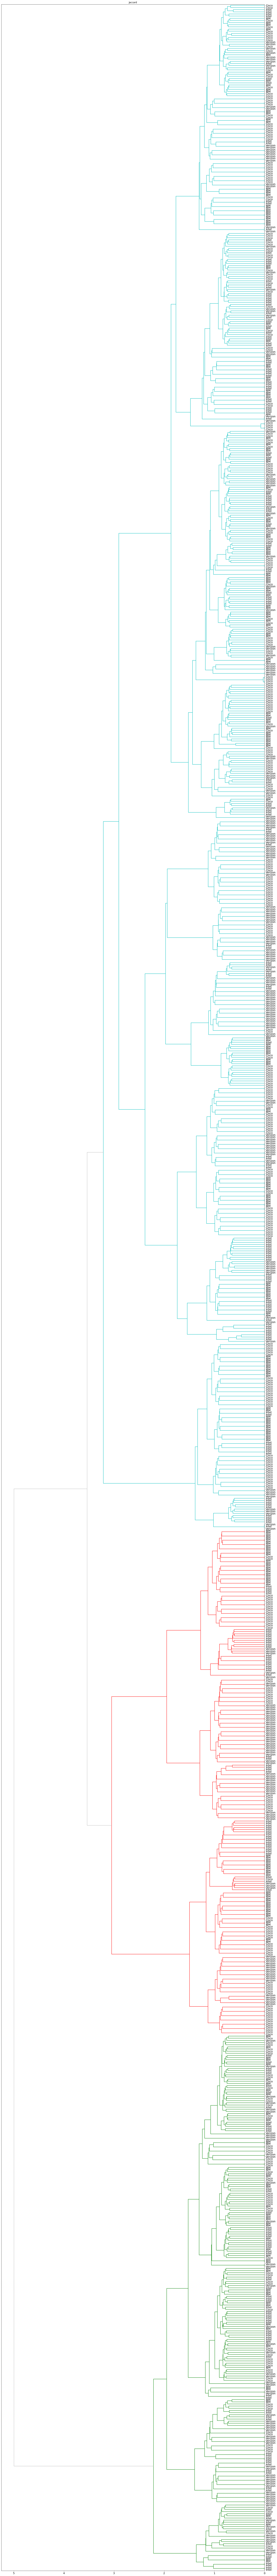

In [320]:
# Using ward linkage method
hca(matrix.loc[:, 'jaccard'])